# Now you're thinking with Simulators

At least, you will by the end of the tutorial.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

import caustic

In [2]:
# Specify the image/cosmology parameters
n_pix = 100
res = 0.05
upsample_factor = 2
fov = res * n_pix
thx, thy = caustic.get_meshgrid(res/upsample_factor, upsample_factor*n_pix, upsample_factor*n_pix, dtype=torch.float32)
z_l = torch.tensor(0.5, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)
cosmology = caustic.FlatLambdaCDM(name = "cosmo")
cosmology.to(dtype=torch.float32)

FlatLambdaCDM(
    name='cosmo',
    static=[h0, critical_density_0, Om0],
    dynamic=[],
    x keys=[]
)

In [3]:
# demo simulator with sersic source, SIE lens. then sample some examples. demo the model graph

class Simple_Sim(caustic.Simulator):
    def __init__(
        self,
        lens,
        src,
        z_s=None,
        name: str = "sim",
    ):
        super().__init__(name) # need this so `Parametrized` can do its magic
        
        # These are the lens and source objects to keep track of
        self.lens = lens
        self.src = src
        
        # Here we can add a parameter to the simulator, in this case it is `z_s` which we will need later
        self.add_param("z_s", z_s)

    def forward(self, params):# define the forward model
        # Here the simulator unpacks the parameter it needs
        z_s = self.unpack(params)

        # Note this is very similar to before, except the packed up `x` is all the raytrace function needs to work
        bx, by = self.lens.raytrace(thx, thy, z_s, params)
        mu_fine = self.src.brightness(bx, by, params)
        
        # We return the sampled brightness at each pixel location
        return avg_pool2d(mu_fine.squeeze()[None, None], upsample_factor)[0, 0]

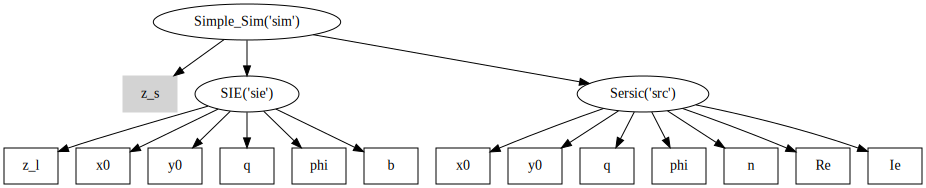

In [4]:
sie = caustic.lenses.SIE(cosmology, name = "sie")
src = caustic.sources.Sersic(name = "src")

sim = Simple_Sim(sie, src, torch.tensor(0.8))

sim.get_graph(True, True)

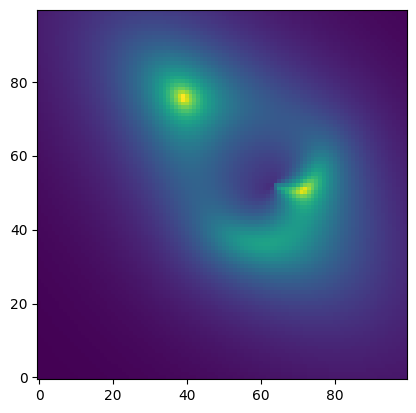

In [5]:
# Reading the x_keys above we can input the parameters that we would like the simulator to evaluate
x = torch.tensor([
    z_l.item(), # sie z_l
    0.7,     # sie x0
    0.13,    # sie y0
    0.4,     # sie q
    np.pi/5, # sie phi
    1.,      # sie b
    0.2,     # src x0
    0.5,      # src y0
    0.5,      # src q
    -np.pi/4, # src phi
    1.5,       # src n
    2.5,      # src Re
    1.,       # src Ie
])
plt.imshow(sim(x), origin="lower")

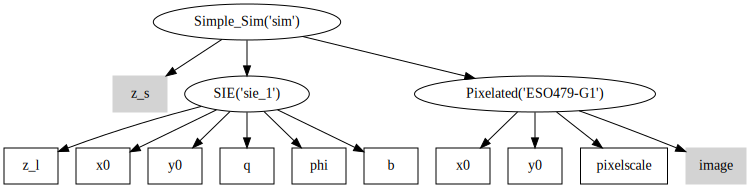

In [7]:
sie = caustic.lenses.SIE(cosmology,name = "sie")
hdu = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=36.3684&dec=-25.6389&size=250&layer=ls-dr9&pixscale=0.262&bands=r")
image_data = np.array(hdu[0].data, dtype = np.float64)
src = caustic.sources.Pixelated(name = "ESO479-G1", image = torch.tensor(image_data, dtype = torch.float32))

sim2 = Simple_Sim(sie, src, torch.tensor(0.8))

sim2.get_graph(True, True)

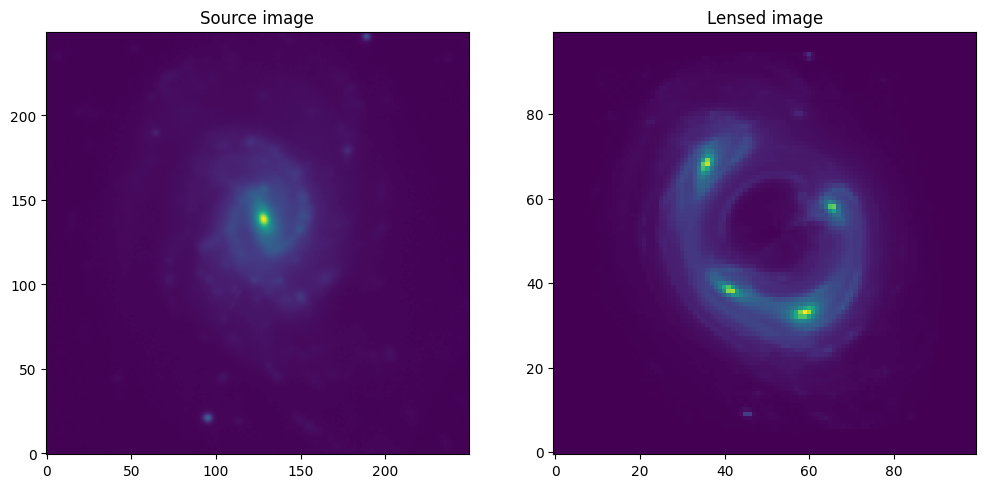

In [8]:
# x can also be a dict
x = torch.tensor([
    z_l.item(), # sie z_l
    0.2,     # sie x0
    0.1,    # sie y0
    0.4,     # sie q
    np.pi/5, # sie phi
    1.,      # sie b
    0.0,     # src x0
    0.0,      # src y0
    0.01,      # src pixelscale
])
fig, axarr = plt.subplots(1, 2, figsize = (12,6))
axarr[0].imshow(image_data, origin = "lower")
axarr[0].set_title("Source image")
axarr[1].imshow(sim2(x), origin="lower")
axarr[1].set_title("Lensed image")
plt.show()

## Setting static/dynamic parameters

So far we have assumed that all parameters for the source and lens are being modelled. However, it is often the case that a parameter can/must be fixed for a given science case. It is very easy to do this in Caustic, simply pass the fixed value when constructing the lens/source objects.

Below we have fixed some parameters in our simulator by providing them when constructing the objects. In the graph they now appear as greyed boxes. In fact we can see now that the cosmology object `FlatLambdaCDM` had fixed parameters all along. This is because there are natural default parameters for such a cosmology. It is possible, of course, to make a different cosmology object which has alternate values, or which leaves some values as free parameters.

In general, to set a parameter as dynamic (must be passed to the simulator) just set it to `None`, to fix a parameter give it a value.

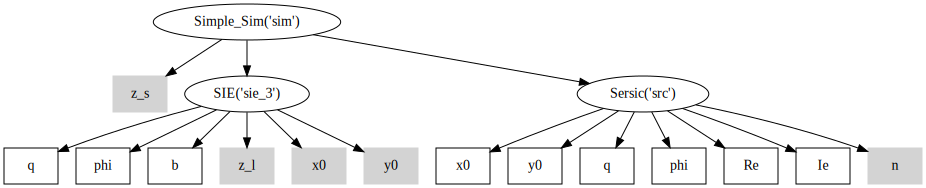

In [10]:
sief = caustic.lenses.SIE(name = "sie", cosmology = cosmology, z_l = torch.tensor(0.5), x0 = torch.tensor(0.), y0 = torch.tensor(0.))
srcf = caustic.sources.Sersic(name = "src", n = torch.tensor(2.))

simf = Simple_Sim(sief, srcf, z_s = torch.tensor(0.8))

simf.get_graph(True, True)

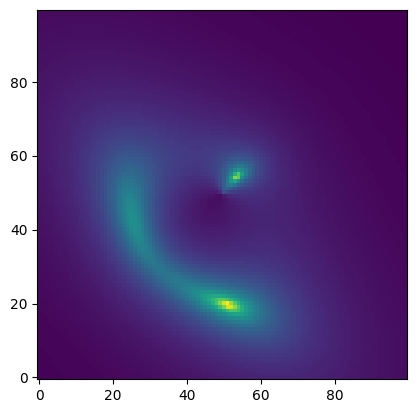

In [11]:
# Reading the x_keys above we can input the parameters that we would like the simulator to evaluate
x = torch.tensor([
    0.4,     # sie q
    np.pi/5, # sie phi
    1.,      # sie b
    -0.2,     # src x0
    -0.5,      # src y0
    0.5,      # src q
    -np.pi/4, # src phi
    2.5,      # src Re
    1.,       # src Ie
])
plt.imshow(simf(x), origin="lower")